In [1]:
import json
import random
import numpy as np
from pathlib import Path

import torchvision.datasets.utils
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
from torchvision.io import read_image
from torchvision.models.segmentation import FCN_ResNet50_Weights
from torchvision.utils import draw_segmentation_masks
import torchvision.transforms.functional as F
import models
from utils import *

In [2]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [3]:
root = r"./data/Pascal VOC 2012/VOCdevkit/VOC2012"
val_txt_path = str(Path(root) / "ImageSets/Segmentation/val.txt")
with open(val_txt_path, "r", encoding="utf-8") as f:
    val_filename_list = f.read().splitlines()
random.shuffle(val_filename_list)
image_list = [read_image(str(Path(root) / "JPEGImages" / (str(filename) + ".jpg"))) for filename in val_filename_list]
target_list = [read_image(str(Path(root) / "SegmentationClass" / (str(filename) + ".png"))) for filename in
               val_filename_list]
len(val_filename_list), len(image_list)

(1449, 1449)

In [4]:
color_json_path = str(Path(root) / "ImageSets/Segmentation/palette.json")
with open(color_json_path, "r", encoding="utf-8") as f:
    color_dict = json.load(f)
class_json_path = str(Path(root) / "ImageSets/Segmentation/pascal_voc_classes.json")
with open(class_json_path, "r", encoding="utf-8") as f:
    class_dict = json.load(f)
len(color_dict), len(class_dict)

(256, 21)

In [5]:
# 预训练时的类别，被保存在预训练权重weight里
sem_class_to_idx = {cls: idx for (idx, cls) in enumerate(FCN_ResNet50_Weights.DEFAULT.meta["categories"])}
num_classes = len(sem_class_to_idx)

model = models.FCN()

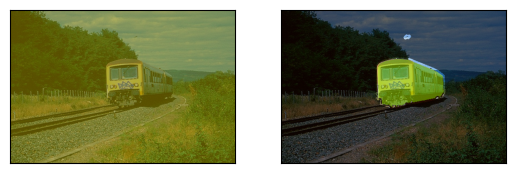

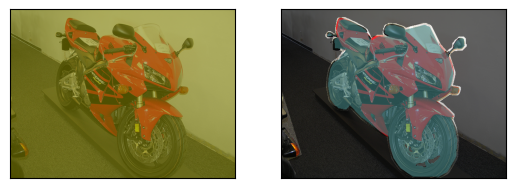

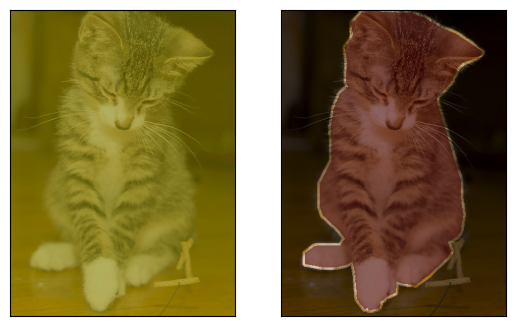

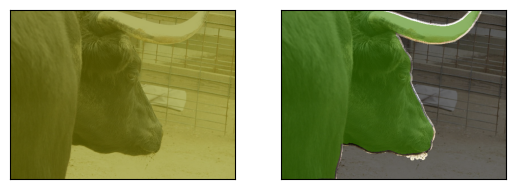

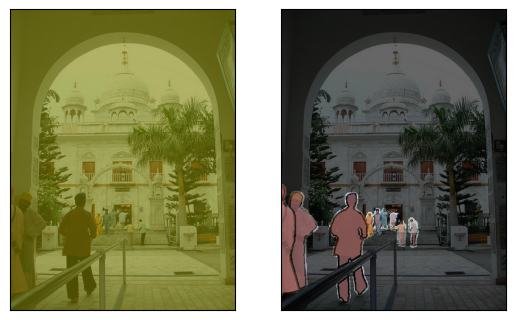

In [6]:
simple_num = 5  # 预测样本数量，通过切片实现

for i in range(simple_num):
    img = image_list[i]
    img_float = F.convert_image_dtype(img).unsqueeze(0)
    # 对21种类别做了判断，所以有dim=1的长度为21
    out_img = model(img_float)
    # 对每个像素的预测结果维度归一化
    normalized_masks = out_img.softmax(dim=1)
    out_masks = normalized_masks.argmax(1) == torch.arange(num_classes)[:, None, None, None]
    out_masks = out_masks.swapaxes(0, 1)
    target_mask = target_list[i][0] == torch.arange(num_classes)[:, None, None]
    out_masks = torch.cat([out_masks, target_mask.unsqueeze(0)], dim=0)
    img_with_masks = [
        draw_segmentation_masks(img, masks=mask, alpha=.6, colors=[tuple(value) for value in color_dict.values()])
        for mask in out_masks
    ]
    show(img_with_masks)

In [5]:
epochs = 3
batch_size = 10
learn_rate = 0.1
momentum = 0.9
optimizer = optim.SGD(model.parameters(), lr=learn_rate, momentum=momentum)
criterion = nn.CrossEntropyLoss()

NameError: name 'model' is not defined

In [6]:
batch_size = 10
train_data = VOCSegmentation(root="./data/Pascal VOC 2012/VOCdevkit/VOC2012",
                             img_set="train",
                             crop_size=(224, 224))
val_data = VOCSegmentation(root="./data/Pascal VOC 2012/VOCdevkit/VOC2012",
                           img_set="val",
                           crop_size=(224, 224))
train_loader = DataLoader(dataset=train_data,
                          batch_size=batch_size,
                          shuffle=True)
val_loader = DataLoader(dataset=val_data,
                        batch_size=batch_size,
                        shuffle=True)

In [9]:
# 运行主训练循环
model.train()
for epoch in range(epochs):
    for batch_idx, (data, target) in enumerate(train_loader):
        output = model(data)
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss.data.item()))

Train Epoch: 0 [0/1456 (0%)]	Loss: 3.043151


KeyboardInterrupt: 

In [24]:
train_data = VOCSegmentation(root="./data/Pascal VOC 2012/VOCdevkit/VOC2012",
                             img_set="train",
                             crop_size=332)
train_data.length

1444